# New  dataset

UnboundLocalError: local variable 'ind' referenced before assignment

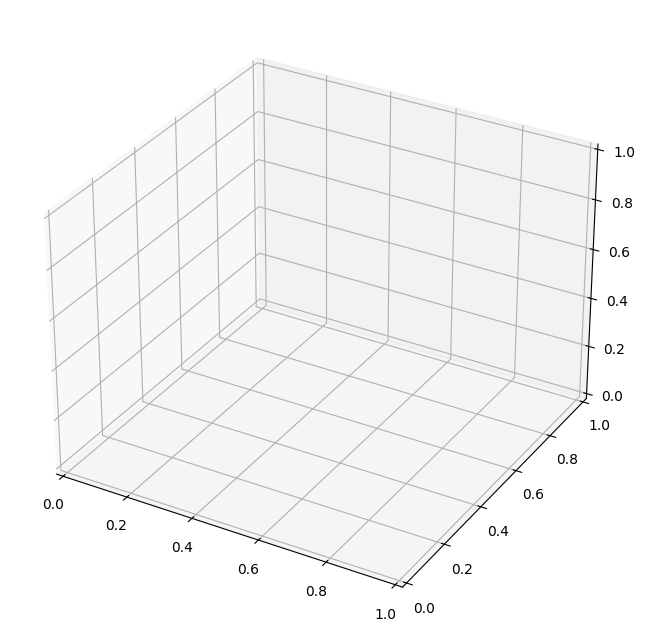

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_points(filename):
    """Загрузка данных из файла с обработкой BOM и разделителей"""
    # Читаем файл как текст, удаляем BOM, затем загружаем в numpy
    with open(filename, 'r', encoding='utf-8-sig') as f:  # utf-8-sig удаляет BOM
        data = np.loadtxt(f, delimiter=None)  # None - автоматическое определение разделителя
    
    positions = data[:, 1:4]  # X, Y, Z
    orientations = data[:, 4:7]  # RZ, RY, RX
    indexes = data[:, 0]
    return positions, orientations, indexes

def visualize_points(positions, orientations, indexes, scale=0.1):
    """Визуализация точек с ориентацией"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Отображаем точки
    if ind == 529:
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=10, label='Точки')
    else:
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='r', s=10, label='Точки')
    
    # Отображаем ориентацию (векторы)
    for pos, ori, ind in zip(positions, orientations, indexes):
        # Преобразуем углы Эйлера в вектор направления
        # (упрощенное представление - можно использовать матрицы поворота для точности)
        rx, ry, rz = ori
        dx = np.cos(rz) * np.cos(ry) * scale
        dy = np.sin(rz) * np.cos(ry) * scale
        dz = np.sin(ry) * scale

        ax.quiver(pos[0], pos[1], pos[2], dx, dy, dz, color='r', length=scale, normalize=True)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Облако ориентированных точек')
    ax.legend()
    plt.show()

# Пример использования
if __name__ == "__main__":
    positions, orientations, indexes = load_points('../data/collect800Points100-20-110/RobotPositions.txt')
    visualize_points(positions, orientations, indexes)


    mesured_positions, mesured_orientations = load_points('../data/AviaStar_TestNormalizeModelV5/MeasuredPositionsTS_ModelForestNewV5.txt')
    # visualize_points(mesured_positions, mesured_orientations)


In [91]:
import pandas as pd
import os
from tqdm import tqdm

def combine_files_with_index_check(folders, target_files, output_file=None):
    """
    Объединяет файлы с проверкой индексов
    
    Параметры:
    - folders: список путей к папкам
    - target_files: имена файлов ['DriveTorque.txt', 'GearTorque.txt', 'Joints.txt']
    - output_file: путь для сохранения (опционально)
    
    Возвращает:
    - Объединенный датафрейм (19 колонок)
    """
    
    # Результирующий датафрейм
    final_df = pd.DataFrame()
    stats = {'total_folders': 0, 'processed_folders': 0, 'errors': 0}
    
    print(f"Обработка {len(folders)} папок...")
    
    for folder in tqdm(folders):
        stats['total_folders'] += 1
        folder_data = {}
        index_ref = None
        valid_folder = True
        
        # Сначала загружаем все файлы из папки и проверяем индексы
        for file_name in target_files:
            file_path = os.path.join(folder, file_name)
            
            try:
                if os.path.exists(file_path):
                    # Чтение файла (7 колонок: индекс + 6 данных)
                    df = pd.read_csv(file_path, sep=' ', header=None, engine='python')
                    
                    # Проверка структуры файла
                    if len(df.columns) != 7:
                        print(f"\nОшибка в {file_path}: ожидается 7 колонок, получено {len(df.columns)}")
                        valid_folder = False
                        break
                        
                    # Устанавливаем индекс (первая колонка)
                    df = df.set_index(0)
                    
                    # Проверка совпадения индексов между файлами
                    if index_ref is None:
                        index_ref = df.index
                    elif not index_ref.equals(df.index):
                        print(f"\nНесовпадение индексов в {file_path}")
                        valid_folder = False
                        break
                        
                    folder_data[file_name] = df
                    
            except Exception as e:
                print(f"\nОшибка чтения {file_path}: {str(e)}")
                valid_folder = False
                break
        
        # Если все файлы загружены и индексы совпадают
        if valid_folder and len(folder_data) == len(target_files):
            try:
                # Горизонтальное объединение (6 колонок из каждого файла)
                combined = pd.concat([
                    # folder_data['DriveTorque.txt'],
                    folder_data['GearTorque.txt'],
                    folder_data['Joints.txt'],
                    folder_data['RobotPositions.txt'],
                    folder_data['MeasuredPositionsTS_Model.txt']
                ], axis=1)
                
                # Проверка количества колонок (5 файла × 6 колонок = 30)
                # if len(combined.columns) != 30:
                #     print(f"\nНеверное количество колонок в {folder}: {len(combined.columns)}")
                #     stats['errors'] += 1
                #     continue
                
                # Добавляем метку папки (19-я колонка)
                # combined['source_folder'] = os.path.basename(folder.rstrip('/'))
                
                # Добавляем к итоговому датафрейму
                final_df = pd.concat([final_df, combined], axis=0)
                stats['processed_folders'] += 1
                
            except Exception as e:
                print(f"\nОшибка объединения в {folder}: {str(e)}")
                stats['errors'] += 1
    
    # Генерация имен колонок
    if not final_df.empty:
        column_names = (
            # [f'DriveTorque_{i}' for i in range(1, 7)] +
            [f'GearTorque_{i}' for i in range(1, 7)] +
            [f'Joints_{i}' for i in range(1, 7)] +
            [f'RobotPositions_{i}' for i in range(1, 7)] +
            [f'MeasuredPositionsTS_Model_{i}' for i in range(1, 7)]
            # +['source_folder']
        )
        
        final_df.columns = column_names
        
        # Сохранение
        if output_file:
            try:
                final_df.to_csv(output_file, index=True)
                print(f"\nРезультат сохранен в {output_file}")
            except Exception as e:
                print(f"\nОшибка сохранения: {str(e)}")
    
    # Статистика
    print("\nСтатистика:")
    print(f"Успешно обработано папок: {stats['processed_folders']}/{stats['total_folders']}")
    print(f"Ошибок: {stats['errors']}")
    print(f"Итоговый размер: {final_df.shape} (ожидается 31 колонок)")
    
    return final_df

# Конфигурация
target_files = ['GearTorque.txt', 'Joints.txt', 'RobotPositions.txt', 'MeasuredPositionsTS_Model.txt']
folders = [
    '../calibS-1/',
    '../data/collect800Points100-20-110/'
    # '../data/calibF/',
    # '../data/robLocate/',
    # '../data/spiraltestS/'
]

# Запуск обработки
result = combine_files_with_index_check(
    folders=folders,
    target_files=target_files,
    output_file='combined_results.csv'
)




Обработка 2 папок...


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 21.13it/s]


Результат сохранен в combined_results.csv

Статистика:
Успешно обработано папок: 2/2
Ошибок: 0
Итоговый размер: (969, 24) (ожидается 31 колонок)


 убрать наблюдение, оставить номинальные позиции

In [92]:
result2 = result.drop(result.columns[-6:],axis=1)
# result2 = result2.drop(['RobotPositions_4','RobotPositions_5'],axis=1)
from sklearn.preprocessing import StandardScaler

cols = result2.columns
idx = result2.index

scaler = StandardScaler()
result2_scaled = pd.DataFrame(scaler.fit_transform(result2), columns=cols, index=idx)

Убрать номинальные позиции, оставить TS_Model наблюдение

In [93]:
result_optic = result.drop(result.columns[-12:-6],axis=1)
# result2 = result2.drop(['RobotPositions_4','RobotPositions_5'],axis=1)
from sklearn.preprocessing import StandardScaler

cols = result_optic.columns
idx = result_optic.index

scaler = StandardScaler()
result_optic_scaled = pd.DataFrame(scaler.fit_transform(result_optic), columns=cols, index=idx)

In [94]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Применяем к нужным столбцам
for col in result_optic_scaled.columns:
    result_optic_scaled = remove_outliers_iqr(result_optic_scaled, col)

In [95]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(
    result_optic_scaled,
    test_size=0.3,          # Доля тестовой выборки (30%)
    random_state=42,        # Фиксируем случайность для воспроизводимости
    shuffle=True            # Перемешивание данных перед разбиением (по умолчанию True)
)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df

Train shape: (638, 18)
Test shape: (274, 18)


,GearTorque_1,GearTorque_2,GearTorque_3,GearTorque_4,GearTorque_5,GearTorque_6,Joints_1,Joints_2,Joints_3,Joints_4,Joints_5,Joints_6,MeasuredPositionsTS_Model_1,MeasuredPositionsTS_Model_2,MeasuredPositionsTS_Model_3,MeasuredPositionsTS_Model_4,MeasuredPositionsTS_Model_5,MeasuredPositionsTS_Model_6
0,,,,,,,,,,,,,,,,,,
661,-1.163526,-0.643464,-1.016948,0.171492,-0.709683,-0.996482,0.787966,-0.253554,-0.424983,0.708620,-0.886124,-0.670018,-0.437764,-0.339972,1.086749,0.404391,-0.352010,-0.032731
762,-1.153073,-0.200642,-0.840228,0.175851,-1.040305,-0.995127,0.968109,0.397216,-1.376759,0.701866,-1.271261,-0.686849,-0.437884,-0.339632,1.576619,0.404611,-0.352434,-0.032616
173,-0.924019,-0.916705,-0.330133,1.475646,1.628431,-1.068208,-0.294896,-0.580719,-0.124956,-2.058026,-0.371235,2.058748,-0.176016,-1.133457,-0.872399,0.403914,-0.356197,-0.032976
484,1.184750,-1.310939,-0.280854,-1.662278,1.689138,1.514475,0.407606,-1.012899,0.065563,0.874696,-0.612643,-0.911955,-0.176669,-0.868966,0.351918,0.403777,-0.354072,-0.032951
725,-1.095810,-0.244429,-0.857222,0.090762,-0.314968,-1.093791,0.843253,0.249444,-1.360704,0.743623,-1.196516,-0.758358,-0.699116,-0.604204,1.331731,0.404555,-0.352543,-0.032804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,-0.623248,0.426260,-0.202854,-0.159501,-0.218775,0.757986,-0.032793,0.447823,0.235039,-1.696065,1.637973,1.815707,1.085354,-0.312259,0.691881,-1.610679,1.927729,-1.264838
162,1.293779,0.505131,0.787883,0.789334,-1.761395,-0.896944,-0.259112,-0.269092,1.632944,-0.799663,-0.005387,0.700147,0.608562,0.715741,-0.872086,0.404543,-0.357663,-0.033293
753,1.230862,0.649634,0.566484,-1.579945,0.665516,1.431067,1.008124,1.228303,-0.011604,0.378491,-0.652088,-0.079605,-0.176221,2.038933,1.331210,0.404697,-0.349898,-0.032885


In [97]:
from sklearn.linear_model import LinearRegression

X_train = train_df.loc[:, :'Joints_6']  # Признаки (колонки 0-17)
y_train = train_df.loc[:, 'MeasuredPositionsTS_Model_1':]  # Целевые (колонки 18-23)
X_test = test_df.loc[:, :'Joints_6'] 
y_test = test_df.loc[:, 'MeasuredPositionsTS_Model_1':]


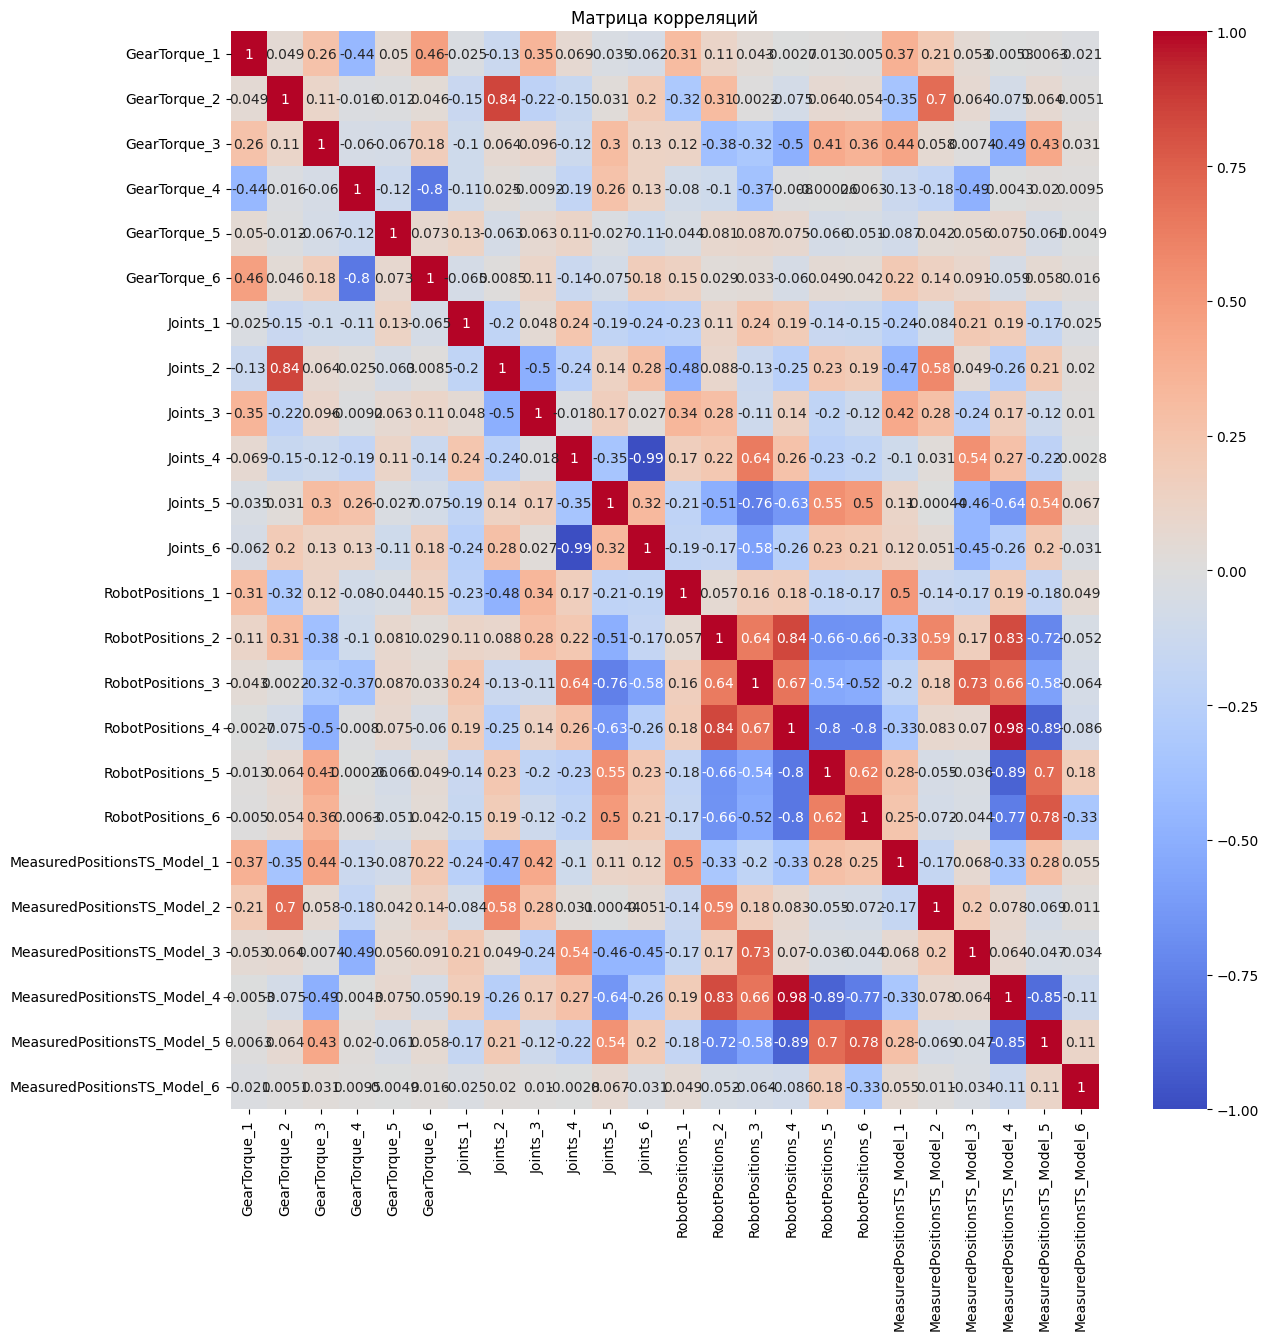

In [98]:

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = result.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Матрица корреляций")
plt.show()

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

class OpticModel(nn.Module):
    def __init__(self):
        super(OpticModel, self).__init__()
        self.fc1 = nn.Linear(12, 64)  
        self.fc2 = nn.Linear(64, 32)   
        self.fc3 = nn.Linear(32, 6) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = OpticModel()

In [100]:
y_train

,MeasuredPositionsTS_Model_1,MeasuredPositionsTS_Model_2,MeasuredPositionsTS_Model_3,MeasuredPositionsTS_Model_4,MeasuredPositionsTS_Model_5,MeasuredPositionsTS_Model_6
0,,,,,,
661,-0.437764,-0.339972,1.086749,0.404391,-0.352010,-0.032731
762,-0.437884,-0.339632,1.576619,0.404611,-0.352434,-0.032616
173,-0.176016,-1.133457,-0.872399,0.403914,-0.356197,-0.032976
484,-0.176669,-0.868966,0.351918,0.403777,-0.354072,-0.032951
725,-0.699116,-0.604204,1.331731,0.404555,-0.352543,-0.032804
...,...,...,...,...,...,...
138,1.085354,-0.312259,0.691881,-1.610679,1.927729,-1.264838
162,0.608562,0.715741,-0.872086,0.404543,-0.357663,-0.033293
753,-0.176221,2.038933,1.331210,0.404697,-0.349898,-0.032885


In [108]:
criterion = nn.MSELoss()  # Функция потерь MSE
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam
num_epochs = 250  # Количество эпох

In [109]:
train_data = TensorDataset(torch.FloatTensor(X_train.to_numpy()), torch.FloatTensor(y_train.to_numpy()))
test_data = TensorDataset(torch.FloatTensor(X_test.to_numpy()), torch.FloatTensor(y_test.to_numpy()))

# Создание DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [110]:
for epoch in range(num_epochs):
    model.train()  # Режим обучения
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Вывод статистики
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/250, Loss: 0.7467
Epoch 2/250, Loss: 0.6630
Epoch 3/250, Loss: 0.5838
Epoch 4/250, Loss: 0.5033
Epoch 5/250, Loss: 0.4260
Epoch 6/250, Loss: 0.3631
Epoch 7/250, Loss: 0.3107
Epoch 8/250, Loss: 0.2716
Epoch 9/250, Loss: 0.2393
Epoch 10/250, Loss: 0.2130
Epoch 11/250, Loss: 0.1936
Epoch 12/250, Loss: 0.1776
Epoch 13/250, Loss: 0.1647
Epoch 14/250, Loss: 0.1548
Epoch 15/250, Loss: 0.1478
Epoch 16/250, Loss: 0.1397
Epoch 17/250, Loss: 0.1334
Epoch 18/250, Loss: 0.1276
Epoch 19/250, Loss: 0.1230
Epoch 20/250, Loss: 0.1179
Epoch 21/250, Loss: 0.1134
Epoch 22/250, Loss: 0.1100
Epoch 23/250, Loss: 0.1058
Epoch 24/250, Loss: 0.1023
Epoch 25/250, Loss: 0.0991
Epoch 26/250, Loss: 0.0961
Epoch 27/250, Loss: 0.0929
Epoch 28/250, Loss: 0.0900
Epoch 29/250, Loss: 0.0877
Epoch 30/250, Loss: 0.0851
Epoch 31/250, Loss: 0.0829
Epoch 32/250, Loss: 0.0805
Epoch 33/250, Loss: 0.0792
Epoch 34/250, Loss: 0.0773
Epoch 35/250, Loss: 0.0760
Epoch 36/250, Loss: 0.0735
Epoch 37/250, Loss: 0.0715
Epoch 38/2

Metric               Feature 1    Feature 2    Feature 3    Feature 4     Feature 5     Feature 6   
----------------------------------------------------------------------------------------------------
R2                  0.9337        0.9912        0.9673        0.9067        0.6329        0.8945        
MSE                 0.0539        0.0078        0.0269        0.0787        0.3517        0.0167        
MAE                 0.1450        0.0656        0.1029        0.1391        0.2919        0.0690        
Explained Variance  0.9337        0.9914        0.9684        0.9068        0.6329        0.8952        


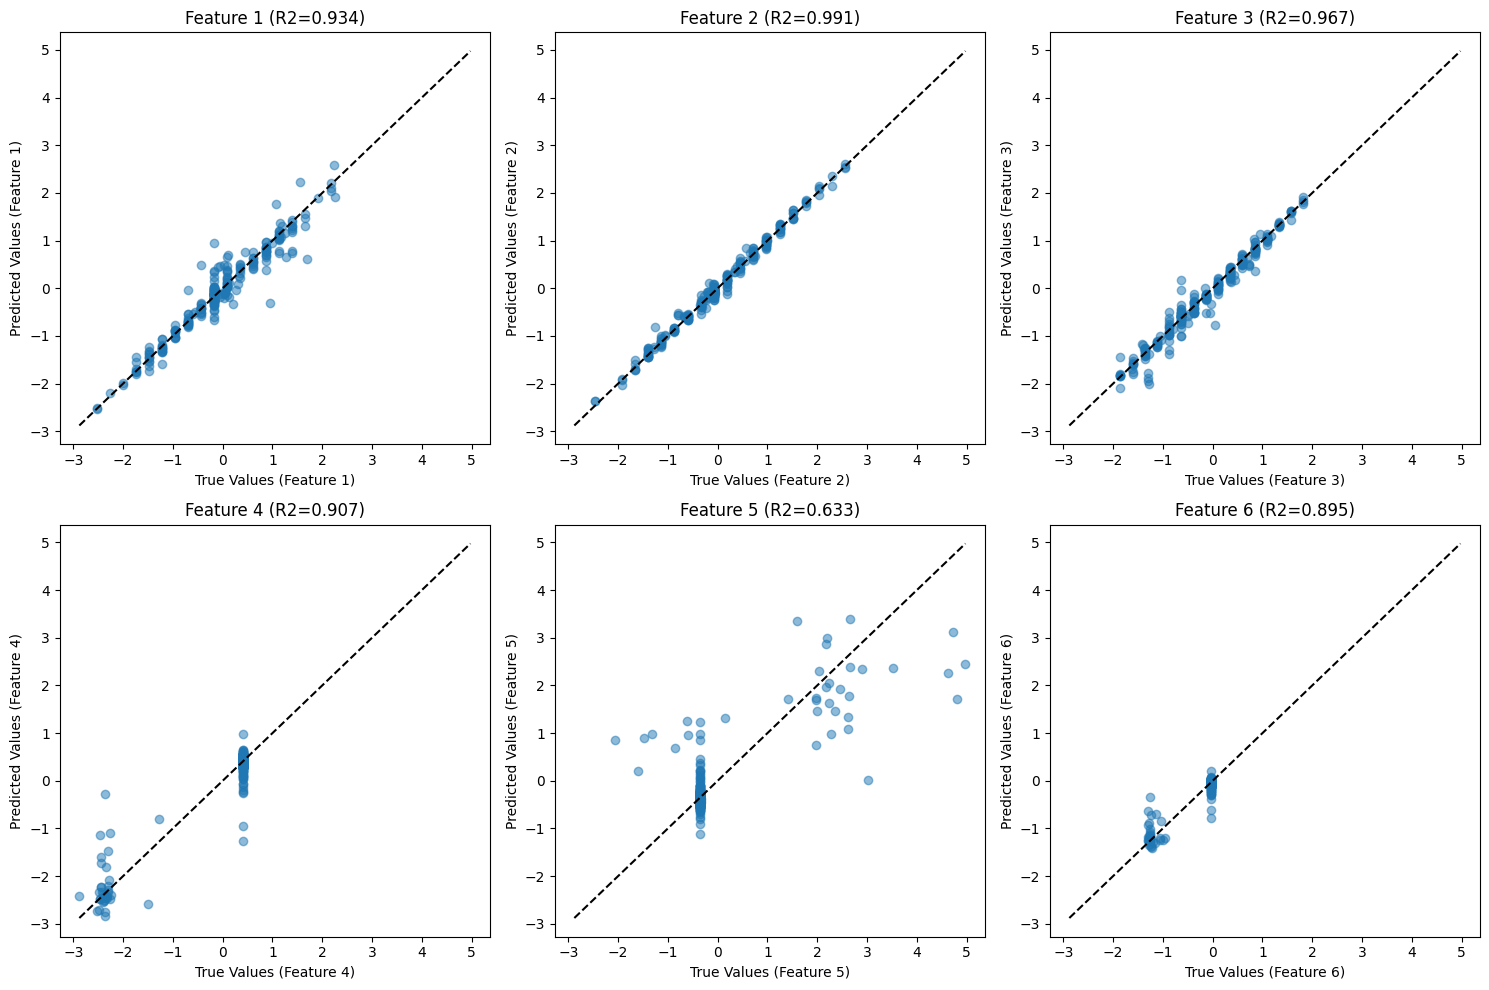


Дополнительные метрики:
Средний R2: 0.8877
Средний MSE: 0.0893
Средний MAE: 0.1356
Объясненная дисперсия: 0.8881


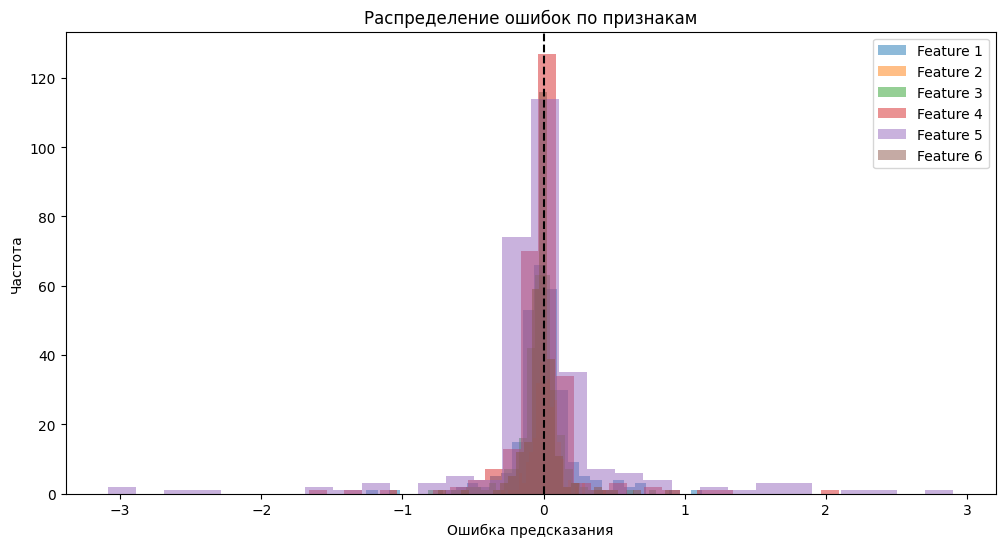

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

# 1. Предсказание на тестовых данных
model.eval()  # Переводим модель в режим оценки
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        all_targets.append(targets.numpy())
        all_predictions.append(outputs.numpy())

# Конвертируем в numpy массивы
y_true = np.vstack(all_targets)
y_pred = np.vstack(all_predictions)

# 2. Вычисление метрик для каждого целевого признака
metrics = {
    'R2': r2_score,
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'Explained Variance': explained_variance_score
}

results = {}
for metric_name, metric_fn in metrics.items():
    results[metric_name] = [metric_fn(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]

# 3. Вывод результатов в таблице
print(f"{'Metric':<20} {'Feature 1':<12} {'Feature 2':<12} {'Feature 3':<12} {'Feature 4':<12}  {'Feature 5':<12}  {'Feature 6':<12}" )
print("-" * 100)
for metric, values in results.items():
    print(f"{metric:<20}", end="")
    for val in values:
        print(f"{val:.4f}".ljust(14), end="")
    print()

# 4. Визуализация результатов
plt.figure(figsize=(15, 10))

# График истинных vs предсказанных значений
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel(f'True Values (Feature {i+1})')
    plt.ylabel(f'Predicted Values (Feature {i+1})')
    plt.title(f'Feature {i+1} (R2={results["R2"][i]:.3f})')

plt.tight_layout()
plt.show()

# 5. Дополнительные метрики (по всем признакам)
print("\nДополнительные метрики:")
print(f"Средний R2: {np.mean(results['R2']):.4f}")
print(f"Средний MSE: {np.mean(results['MSE']):.4f}")
print(f"Средний MAE: {np.mean(results['MAE']):.4f}")
print(f"Объясненная дисперсия: {explained_variance_score(y_true, y_pred, multioutput='uniform_average'):.4f}")

# 6. Гистограмма ошибок
errors = y_pred - y_true
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.hist(errors[:, i], bins=30, alpha=0.5, label=f'Feature {i+1}')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок по признакам')
plt.legend()
plt.show()